In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from formulaic import model_matrix
from formulaic import Formula



In [6]:
!pip install seaborn
!pip install seaborn.objects
!pip install scikit-learn
!pip install formulaic

ERROR: Could not find a version that satisfies the requirement seaborn.objects (from versions: none)
ERROR: No matching distribution found for seaborn.objects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 27.0 MB/s eta 0:00:00


# Prepocesamiento
En muchos casos, necesitamos realizar algunas transformaciones previas en los datos antes de ajustar un modelo de regresión.
Estas transformaciones pueden ser:
1. Normalizar variables numéricas, escalándolas para que los valores caigan en el intervalo [0,1]
2. Normalizar variables numéricas llevándolas a media 0 y varianza 1.
3. Transformar variables binarias a 0-1.
4. Transformar variables categóricas a variables indicadoras (variables dummies).


## Ejemplo 1: escalamiento MinMax

Este escalamiento es una transformación lineal. Es decir, se aplica una fórmula de la forma
$$
x_{\text{nuevo}} = a \cdot x + b
$$

Los valores de $a$ y $b$ se eligen de forma que los valores de la variable transformada se encuentren en el intervalo [0,1].

La fórmula que debemos aplicar es
$$
x_{\text{nuevo}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$


**Pregunta:** ¿Cuáles pueden ser las ventajas de este escalamiento, comparado con solamente dividir con el máximo?

<details> <summary>Respuesta (click aquí)</summary>
El escalamiento MinMax lleva a que todas las variables tengan una dispersión similar y por lo tanto podamos comparar el peso de cada variable en el modelo mirando los coeficientes.

Ejemplo: si una variable tiene todos valores entre 390 y 400, si solo dividimos por el máximo quedaron valores entre 0.975 y 1. Para que esas pequeñas diferencias impacten en el modelo, necesitaremos multiplicar la variable por un coeficiente alto.
    
Supongamos que   
    
1. $x_1$ tiene valores en el intervalo $[0,1]$ 
2. $x_2$ tiene valores en el intervalo $[0.975, 1]$
    
En un modelo
$$ y = 4 x_1 + 4 x_2$$
la variable $x_1$ tiene más peso. Las observaciones con puntaje alto van a ser las que tenga un valor de $x_1$ alto, las variaciones en $x_2$ van a tener un aporte muy menor.
    
Ejemplo: en muchos concursos docentes, la prueba de oposición tiene un puntaje alto (50 o 70 puntos sobre 100), y por lo tanto a priori es la parte más importante del concurso. Sin embargo en muchos concursos los valores son similares, la mayoria entre 60 y 70. Por lo tanto el peso de la prueba de oposición en el concurso termina siendo mucho menor.
</details>

**Pregunta:** ¿En qué situación este escalamiento podría resultar inadecuado?

<details>
    <summary>Respuesta (click aquí)</summary>

Este escalamiento se ve muy influenciado por la presencia de outliers.
    
Si tenemos outliers en una variable, llevaremos el outlier a 1, y los demás valores a valores muy pequeños.
</details>

Utilizaremos este escalamiento para ajustar datos de infecciones en hospitales. En la siguiente base se calcularon diversas estadísticas sobre 111 hospitales.

In [9]:
infecciones = pd.read_csv("../UBA-LaboDeDatos/infeccion_hospitales.csv")
infecciones.head()

,Id,Dias,Edad,Riesgo,Estudios,RayosX,Camas,Afiliado,Region,Pacientes,Enfermeros
0,1,7.13,55.7,4.1,9.0,39.6,279,No,W,207,241
1,2,8.82,58.2,1.6,3.8,51.7,80,No,NC,51,52
2,3,8.34,56.9,2.7,8.1,74.0,107,No,S,82,54
3,4,8.95,53.7,5.6,18.9,122.8,147,No,W,53,148
4,5,11.20,56.5,5.7,34.5,88.9,180,No,NE,134,151


### Ejemplo: modelo lineal multivariado

Vamos a intentar predecir la variable de riesgo de infección en función de las variables 
1. Cantidad promedio de días de internación (Dias)
2. Edad promedio (Edad)
3. Porcentaje de rayos X por paciente (RayosX)

In [10]:
X = infecciones[["Dias", "Edad", "RayosX"]]
y = infecciones["Riesgo"]

In [12]:
# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression()  # alpha is the hyperparameter equivalent to lambda

# Entrenamiento
modeloLineal.fit(X, y) # calcula los coeficientes del modulo y lo guarda

# Predicciones
y_pred = modeloLineal.predict(X) #aplicamos la formula a datos

# Evaluación (bondad del modelo)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")

# R cuadrado
r2_score(y, y_pred)

Raíz del Error Cuadrático Medio: 1.06547


0.362990531271563

Obtenemos un R^2 relativamente bajo, pero normal en muchos modelos. 

¿Cuál es la variable más importante en el modelo? Miramos los coeficientes...

In [13]:
modeloLineal.coef_

array([ 0.3081809 , -0.02300522,  0.01966093])

La primera variable tiene un coeficiente mucho mayor, pero podemos comparar estos coeficientes?

Miremos los rangos de las variables...

<Axes: >

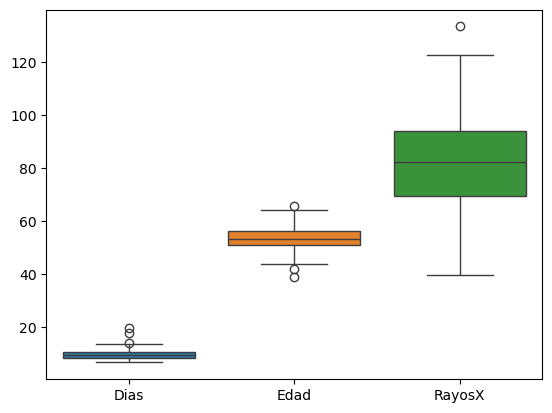

In [93]:
sns.boxplot(X)

Vemos que hay mucha diferencia en las escalas de las variables. Para poder comparar mejor los coeficientes, 
escalamos todas la variables al intervalo [0,1].

¿Cómo aplicamos el escalamiento

$$
x_{\text{nuevo}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

en las columnas de un DataFrame? ($x_{\min}$ y $x_{\max}$ son el mínimo y máximo de cada columna.)

In [94]:
# Calculamos primero el mínimo
X.min()

Dias       6.7
Edad      38.8
RayosX    39.6
dtype: float64

In [14]:
# Restamos el mínimos de cada columna a la columna correspondiente, y verificamos.
X_scaled = (X - X.min())
X_scaled.min()   # ¿Cuál esperamos que sea el resultado?

Dias      0.0
Edad      0.0
RayosX    0.0
dtype: float64

In [15]:
# Ahora dividimos las columnas por x_max - x_min
X_scaled = (X - X.min()) / (X.max() - X.min())
print(X_scaled.min())
print(X_scaled.max())

Dias      0.0
Edad      0.0
RayosX    0.0
dtype: float64
Dias      1.0
Edad      1.0
RayosX    1.0
dtype: float64


## Preprocesamiento con sklearn
Utilizamos ahora MinMaxScaler de `sklearn` para las transformaciones.

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().set_output(transform="pandas") # La última opción hace que nos devuelva un DataFrame

<Axes: >

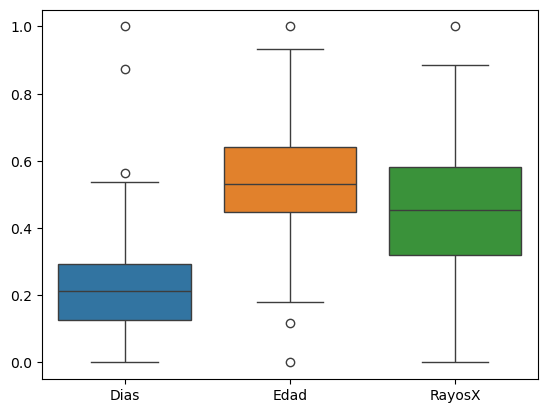

In [33]:
# fit_transform calcula los coeficientes de la transformación y la aplica.
X_scaled = scaler.fit_transform(X)
sns.boxplot(X_scaled)

**Nota:** Vamos a ver más adelante que en ocasiones es útil calcular primero la función de escalamiento (fit) en un conjunto de datos y luego aplicarla (transform) en otro conjunto. sklearn permite hacer estas operaciones en forma separada.

**Escalamiento MinMax y modelo lineal** 

Escalamos las variables utilizando escalamiento MinMax.

La regresión lineal ordinaria es invariante por escalamiento lineal.

Esto quiere decir que si bien los coeficientes van a cambiar, las predicciones se van a mantener iguales.

El escalamiento no va a mejorar el modelo, pero nos permite comparar mejor los coeficientes.

Dado que solo queremos comparar coeficientes, no es necesario escalar la variable respuesta $y$.

In [34]:
# Realizamos nuevamente el ajuste lineal utilizando las variables escaladas

# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression() 

# Entrenamiento
modeloLineal.fit(X_scaled, y)

# Predicciones
y_pred = modeloLineal.predict(X_scaled)

# Evaluación
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 1.06547
R cuadrado: 0.36299


Verificamos que obtuvimos el mismo error cuadrativo y R^2.

In [35]:
# Comparamos los coeficientes
modeloLineal.coef_

array([ 3.96320643, -0.62344145,  1.84616127])

Vemos ahora que no hay tanta diferencia entre los coeficientes.

## Ejemplo 2: escalamiento a misma media y varianza

Si observamos los box-plot, vemos que el escalamiento de la variable de días de internación se vio influenciada por la presencia de outliers, los valores quedaron más apretados que en las otras variables.

Otro escalamiento común es llevar todas las variables a media 0 y varianza 1.

Las principales ventajas son:
1. Menor sensibilidad que min-max (aunque no inmune) a outliers
2. La variabilidad explicada por cada variable se puede ver directamente comparando coeficientes

Posibles ventajas de min-max:
1. Es más simple
2. No introduce valores negativos (que pueden traer problemas si aplicamos logaritmos u otras funciones)



**Paso 1:**
Llevamos las variables a media 0, restando la media.

In [36]:
X_standard = X - X.mean()
X_standard.mean()

Dias     -3.772793e-16
Edad      4.464472e-15
RayosX   -3.772793e-16
dtype: float64

In [37]:
X_standard.var()

Dias        3.653664
Edad       19.905940
RayosX    374.957762
dtype: float64

**Paso 2:** Llevamos a varianza 1, dividiendo por la varianza

In [38]:
X_standard = (X - X.mean()) / np.sqrt(X.var())
X_standard.var()

Dias      1.0
Edad      1.0
RayosX    1.0
dtype: float64

La fórmula general es
$$
\tilde x = \frac{x - \bar x}{\sigma},
$$
donde $\bar x$ es la media y $\sigma$ es el desvío estándar.

In [39]:
# Podemos hacerlo también usando sklearn

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform="pandas") # La última opción hace que nos devuelva un DataFrame

# fit_transform calcula los coeficientes de la transformación y la aplica.
X_scaled = scaler.fit_transform(X)
X_scaled


,Dias,Edad,RayosX
0,-1.323356,0.555660,-2.180123
1,-0.435275,1.118492,-1.552463
2,-0.687511,0.825819,-0.395702
3,-0.366961,0.105394,2.135687
4,0.815396,0.735766,0.377202
...,...,...,...
108,1.130691,0.127907,1.829638
109,-0.077940,-0.885190,-0.556507
110,-1.023825,0.825819,-0.712125
111,4.357210,0.668226,0.527633


<Axes: >

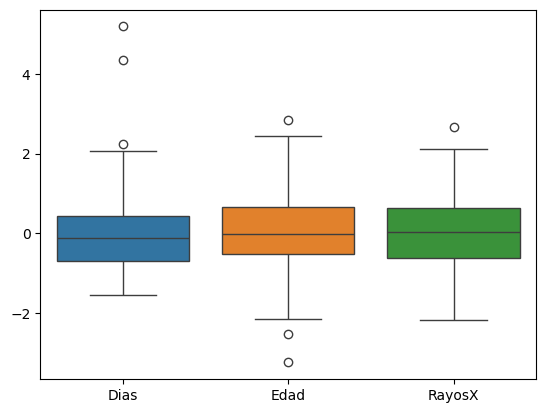

In [27]:
# Realizamos los boxplot
sns.boxplot(X_standard)

In [28]:
# Realizamos nuevamente el ajuste lineal utilizando las variables estandarizadas

# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression() 

# Entrenamiento
modeloLineal.fit(X_standard, y)

# Predicciones
y_pred = modeloLineal.predict(X_standard)

# Evaluación
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 1.06547
R cuadrado: 0.36299


In [29]:
modeloLineal.coef_

array([ 0.58907424, -0.10264026,  0.38071082])

Observamos que la variable con coeficiente mayor sigue siendo "días de internación" y que el coeficiente de la variable "rayos X" está más cerca que antes, indicando un peso similar en el modelo.

## 3. Variables binarias

Queremos incorporar el modelo la variable "Medical School Affiliation", que es variable que toma valores Sí y No. ¿Cómo podemos hacerlo?

Una posibilidad es convertir "Sí" a 1 y "No" a 0.

Otra posibilidad es separar nuestra base en dos, y hacer dos modelos distintos para los hospitales afiliados y los no afiliados.

Vamos a utilizar la primera opción.

In [47]:
infecciones

,Id,Dias,Edad,Riesgo,Estudios,RayosX,Camas,Afiliado,Region,Pacientes,Enfermeros
0,1,7.13,55.7,4.1,9.0,39.6,279,No,W,207,241
1,2,8.82,58.2,1.6,3.8,51.7,80,No,NC,51,52
2,3,8.34,56.9,2.7,8.1,74.0,107,No,S,82,54
3,4,8.95,53.7,5.6,18.9,122.8,147,No,W,53,148
4,5,11.20,56.5,5.7,34.5,88.9,180,No,NE,134,151
...,...,...,...,...,...,...,...,...,...,...,...
108,109,11.80,53.8,5.7,9.1,116.9,571,Si,NC,441,469
109,110,9.50,49.3,5.8,42.0,70.9,98,No,S,68,46
110,111,7.70,56.9,4.4,12.2,67.9,129,No,W,85,136
111,112,17.94,56.2,5.9,26.4,91.8,835,Si,NE,791,407


In [40]:
# Verificamos que son los únicos valores
infecciones.Afiliado.unique()

array(['No', 'Si'], dtype=object)

In [41]:
# Usamos map para convertir los valores
infecciones["I_afiliado"] = infecciones["Afiliado"].map({'Si': 1, 'No': 0})
infecciones

# Pregunta: ¿Qué otras opciones tenemos?

,Id,Dias,Edad,Riesgo,Estudios,RayosX,Camas,Afiliado,Region,Pacientes,Enfermeros,I_afiliado
0,1,7.13,55.7,4.1,9.0,39.6,279,No,W,207,241,0
1,2,8.82,58.2,1.6,3.8,51.7,80,No,NC,51,52,0
2,3,8.34,56.9,2.7,8.1,74.0,107,No,S,82,54,0
3,4,8.95,53.7,5.6,18.9,122.8,147,No,W,53,148,0
4,5,11.20,56.5,5.7,34.5,88.9,180,No,NE,134,151,0
...,...,...,...,...,...,...,...,...,...,...,...,...
108,109,11.80,53.8,5.7,9.1,116.9,571,Si,NC,441,469,1
109,110,9.50,49.3,5.8,42.0,70.9,98,No,S,68,46,0
110,111,7.70,56.9,4.4,12.2,67.9,129,No,W,85,136,0
111,112,17.94,56.2,5.9,26.4,91.8,835,Si,NE,791,407,1


In [55]:
# También podemos usar Formulaic que hace la codificación automáticamente.
y, X = (
    Formula('Riesgo ~ Dias + Edad + RayosX + Afiliado')
    .get_model_matrix(infecciones)
)

In [57]:
X

,Intercept,Dias,Edad,RayosX,Afiliado[T.Si]
0,1.0,7.13,55.7,39.6,0
1,1.0,8.82,58.2,51.7,0
2,1.0,8.34,56.9,74.0,0
3,1.0,8.95,53.7,122.8,0
4,1.0,11.20,56.5,88.9,0
...,...,...,...,...,...
108,1.0,11.80,53.8,116.9,1
109,1.0,9.50,49.3,70.9,0
110,1.0,7.70,56.9,67.9,0
111,1.0,17.94,56.2,91.8,1


**Pregunta:** es necesario agregar también una variable que indique si el hospital NO está afiliado?

**Respuesta:** cuando hay intercept, no necesitamos agregar esa columna, porque estaríamos agregando variables linealmente dependientes:

Intercept = Afiliado[T.Si] + Afiliado[T.No]

En modelos lineales, variables dependientes no solo son innecesarias sino que además agregan inestabilidad en la solución, hay infinitas soluciones al problema de mínimos cuadrados.

**Importante:** Si no usamos intercept, entonces tiene sentido utilizar las dos indicadoras!

In [49]:
# Qué hace formulaic cuando no hay intercept?
y, X = (
    Formula('Riesgo ~ Dias + Edad + RayosX + Afiliado - 1')
    .get_model_matrix(infecciones)
)

X

,Dias,Edad,RayosX,Afiliado[No],Afiliado[Si]
0,7.13,55.7,39.6,1,0
1,8.82,58.2,51.7,1,0
2,8.34,56.9,74.0,1,0
3,8.95,53.7,122.8,1,0
4,11.20,56.5,88.9,1,0
...,...,...,...,...,...
108,11.80,53.8,116.9,0,1
109,9.50,49.3,70.9,1,0
110,7.70,56.9,67.9,1,0
111,17.94,56.2,91.8,0,1


In [50]:
# Veamos cómo mejora nuestro modelo utilizando esta variable.
# (no es necesario escalar variables si solo queremos ver la "bondad" del modelo)
y, X = (
    Formula('Riesgo ~ Dias + Edad + RayosX + Afiliado')
    .get_model_matrix(infecciones)
)

# Realizamos nuevamente el ajuste lineal utilizando las variables estandarizadas

# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression() 

# Entrenamiento
modeloLineal.fit(X, y)

# Predicciones
y_pred = modeloLineal.predict(X)

# Evaluación
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 1.06115
R cuadrado: 0.36814


Obtuvimos una muy leve mejora, no es una variable relevante en el modelo.

## 4. Variables categóricas (One Hot Encoding)

Queremos incorporar ahora la variable "Region". Veamos qué valores toma esta variable.

In [51]:
infecciones.Region.unique()

array(['W', 'NC', 'S', 'NE'], dtype=object)

En este caso no podemos usar una variable 0-1 para codificar 4 valores.

Podríamos usar una variable con 4 valores 1,2,3,4?

Esto podemos hacerlo en algunos casos para variables categóricas ordinales, pero NO para variables nominales. ¿Por qué?

En este caso, vamos a agregar variables "indicadoras" o variables dummies (*dummy* significa maniquí, no es la variable real sino una variable que reemplaza los valores reales).

Para cada categoría agregamos una variable 0-1 que indica si la observación pertenece a la categoría.

In [71]:
# En este caso usar map es medio engorroso...
infecciones["Region_W"] = infecciones.Region.map({"W": 1, "NC": 0, "S": 0, "NE": 0})
infecciones

,Id,Dias,Edad,Riesgo,Estudios,RayosX,Camas,Afiliado,Region,Pacientes,Enfermeros,I_afiliado,Region_W
0,1,7.13,55.7,4.1,9.0,39.6,279,No,W,207,241,0,1
1,2,8.82,58.2,1.6,3.8,51.7,80,No,NC,51,52,0,0
2,3,8.34,56.9,2.7,8.1,74.0,107,No,S,82,54,0,0
3,4,8.95,53.7,5.6,18.9,122.8,147,No,W,53,148,0,1
4,5,11.20,56.5,5.7,34.5,88.9,180,No,NE,134,151,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,109,11.80,53.8,5.7,9.1,116.9,571,Si,NC,441,469,1,0
109,110,9.50,49.3,5.8,42.0,70.9,98,No,S,68,46,0,0
110,111,7.70,56.9,4.4,12.2,67.9,129,No,W,85,136,0,1
111,112,17.94,56.2,5.9,26.4,91.8,835,Si,NE,791,407,1,0


In [73]:
# Podemos simplemente comparar con "W" y multiplicar por 1 para convertir True a 1 y False a 0.
infecciones["Region_W"] = (infecciones.Region == "W")*1
infecciones

,Id,Dias,Edad,Riesgo,Estudios,RayosX,Camas,Afiliado,Region,Pacientes,Enfermeros,I_afiliado,Region_W
0,1,7.13,55.7,4.1,9.0,39.6,279,No,W,207,241,0,1
1,2,8.82,58.2,1.6,3.8,51.7,80,No,NC,51,52,0,0
2,3,8.34,56.9,2.7,8.1,74.0,107,No,S,82,54,0,0
3,4,8.95,53.7,5.6,18.9,122.8,147,No,W,53,148,0,1
4,5,11.20,56.5,5.7,34.5,88.9,180,No,NE,134,151,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,109,11.80,53.8,5.7,9.1,116.9,571,Si,NC,441,469,1,0
109,110,9.50,49.3,5.8,42.0,70.9,98,No,S,68,46,0,0
110,111,7.70,56.9,4.4,12.2,67.9,129,No,W,85,136,0,1
111,112,17.94,56.2,5.9,26.4,91.8,835,Si,NE,791,407,1,0


In [54]:
# Y podemos hacerlo también automáticamente con Formulaic
# Qué hace formulaic cuando no hay intercept?
y, X = (
    Formula('Riesgo ~ Dias + Edad + RayosX + Afiliado + Region ')
    .get_model_matrix(infecciones)
)

X

,Intercept,Dias,Edad,RayosX,Afiliado[T.Si],Region[T.NE],Region[T.S],Region[T.W]
0,1.0,7.13,55.7,39.6,0,0,0,1
1,1.0,8.82,58.2,51.7,0,0,0,0
2,1.0,8.34,56.9,74.0,0,0,1,0
3,1.0,8.95,53.7,122.8,0,0,0,1
4,1.0,11.20,56.5,88.9,0,1,0,0
...,...,...,...,...,...,...,...,...
108,1.0,11.80,53.8,116.9,1,0,0,0
109,1.0,9.50,49.3,70.9,0,0,1,0
110,1.0,7.70,56.9,67.9,0,0,0,1
111,1.0,17.94,56.2,91.8,1,1,0,0


*Pregunta:* Por qué hay solo 3 variables indicadoras?

Nuevamente, queremos evitar dependencia lineal entre variables, siempre (si hay intercept) agregamos una variable menos que la cantidad total de categorías.

In [76]:
# Veamos cómo mejora nuestro modelo utilizando esta variable.
# (no es necesario escalar variables si solo queremos ver la "bondad" del modelo)
y, X = (
    Formula('Riesgo ~ Dias + Edad + RayosX + Afiliado + Region')
    .get_model_matrix(infecciones)
)

# Realizamos nuevamente el ajuste lineal utilizando las variables estandarizadas

# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression() 

# Entrenamiento
modeloLineal.fit(X, y)

# Predicciones
y_pred = modeloLineal.predict(X)

# Evaluación
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 1.03135
R cuadrado: 0.40313


En esta ocasión vemos una mejor más significativa en el R^2.

In [78]:
Para terminar el ejemplo, veamos qué pasa si agregamos todas las variables.

SyntaxError: invalid syntax (2560284829.py, line 1)

In [56]:
# Veamos cómo mejora nuestro modelo utilizando esta variable.
# (no es necesario escalar variables si solo queremos ver la "bondad" del modelo)
y, X = (
    Formula('Riesgo ~ Dias + Edad + Estudios + RayosX + Camas + Afiliado + Region + Pacientes + Enfermeros')
    .get_model_matrix(infecciones)
)

# Realizamos nuevamente el ajuste lineal utilizando las variables estandarizadas

# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression() 

# Entrenamiento
modeloLineal.fit(X, y)

# Predicciones
y_pred = modeloLineal.predict(X)

# Evaluación
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.87741
R cuadrado: 0.56802


Qué otra posibilidad tenemos para manejar la región?
Podemos hacer distintos modelos para cada región. Veamos si esto mejora las predicciones.

In [62]:
infecciones_W = infecciones[infecciones.Region == "W"]
infecciones_W

,Id,Dias,Edad,Riesgo,Estudios,RayosX,Camas,Afiliado,Region,Pacientes,Enfermeros,I_afiliado
0,1,7.13,55.7,4.1,9.0,39.6,279,No,W,207,241,0
3,4,8.95,53.7,5.6,18.9,122.8,147,No,W,53,148,0
16,17,8.28,48.1,4.5,26.0,101.8,108,No,W,84,73,0
20,21,7.53,42.0,4.2,23.1,98.9,95,No,W,47,49,0
24,25,9.20,52.2,4.0,17.5,71.1,298,Si,W,244,236,1
45,46,10.16,54.2,4.6,8.4,51.5,831,Si,W,581,629,1
56,57,7.14,59.0,3.7,2.6,75.8,70,No,W,37,35,0
57,58,7.65,47.1,4.3,16.4,65.7,318,No,W,265,314,0
62,63,7.93,64.1,5.4,7.5,98.1,68,No,W,42,49,0
75,76,6.70,48.6,4.5,13.0,80.8,76,No,W,51,79,0


In [82]:
# Veamos cómo mejora nuestro modelo utilizando esta variable.
# (no es necesario escalar variables si solo queremos ver la "bondad" del modelo)
y, X = (
    Formula('Riesgo ~ Dias + Edad + Estudios + RayosX + Camas + Afiliado + Region + Pacientes + Enfermeros')
    .get_model_matrix(infecciones_W)
)
X

,Intercept,Dias,Edad,Estudios,RayosX,Camas,Afiliado[T.Si],Pacientes,Enfermeros
0,1.0,7.13,55.7,9.0,39.6,279,0,207,241
3,1.0,8.95,53.7,18.9,122.8,147,0,53,148
16,1.0,8.28,48.1,26.0,101.8,108,0,84,73
20,1.0,7.53,42.0,23.1,98.9,95,0,47,49
24,1.0,9.20,52.2,17.5,71.1,298,1,244,236
45,1.0,10.16,54.2,8.4,51.5,831,1,581,629
56,1.0,7.14,59.0,2.6,75.8,70,0,37,35
57,1.0,7.65,47.1,16.4,65.7,318,0,265,314
62,1.0,7.93,64.1,7.5,98.1,68,0,42,49
75,1.0,6.70,48.6,13.0,80.8,76,0,51,79


In [83]:
# Realizamos nuevamente el ajuste lineal utilizando las variables estandarizadas

# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression() 

# Entrenamiento
modeloLineal.fit(X, y)

# Predicciones
y_pred = modeloLineal.predict(X)

# Evaluación
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.73555
R cuadrado: 0.24886


In [ ]:
Bajó el error cuadrático medio pero también bajó el R cuadrado, no hay una clara ventaja en separar por región.

**Ejercicio:** Realizar un modelo lineal para predecir el peso de los pingüinos utilziando las demás variables. ¿Cómo se codifica cada variable? 

Pregunta: ¿Es conveniente separar en distintos grupos? Vamos a verlo más adelante!

In [67]:
penguins = sns.load_dataset("penguins").dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


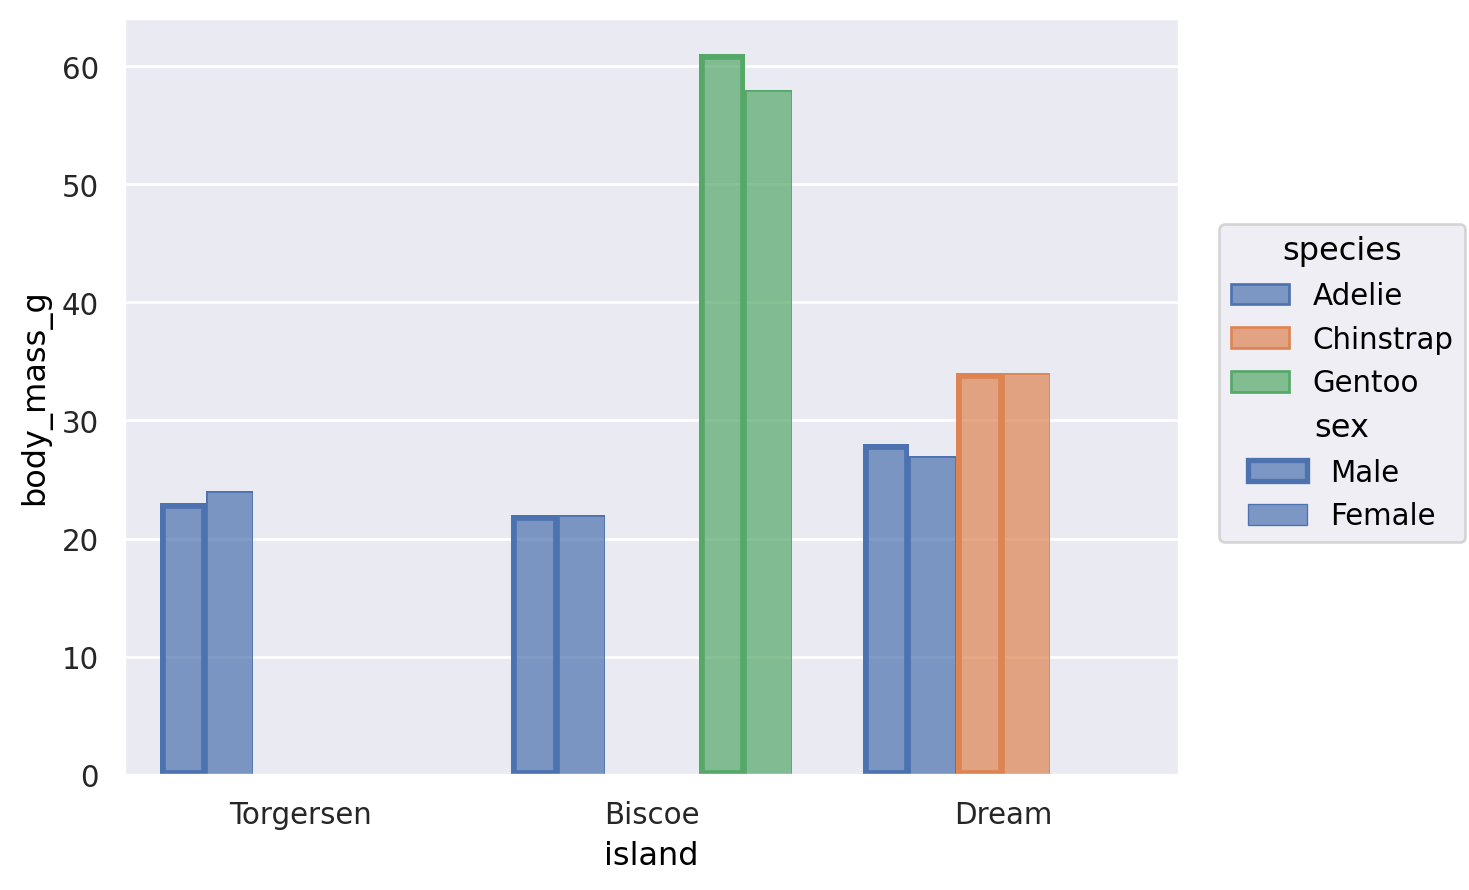

In [77]:
(
    so.Plot(data = penguins, x = "island",y = "body_mass_g")
    .add(so.Bar(), so.Hist(), so.Dodge(), color = "species", edgewidth = "sex")
)

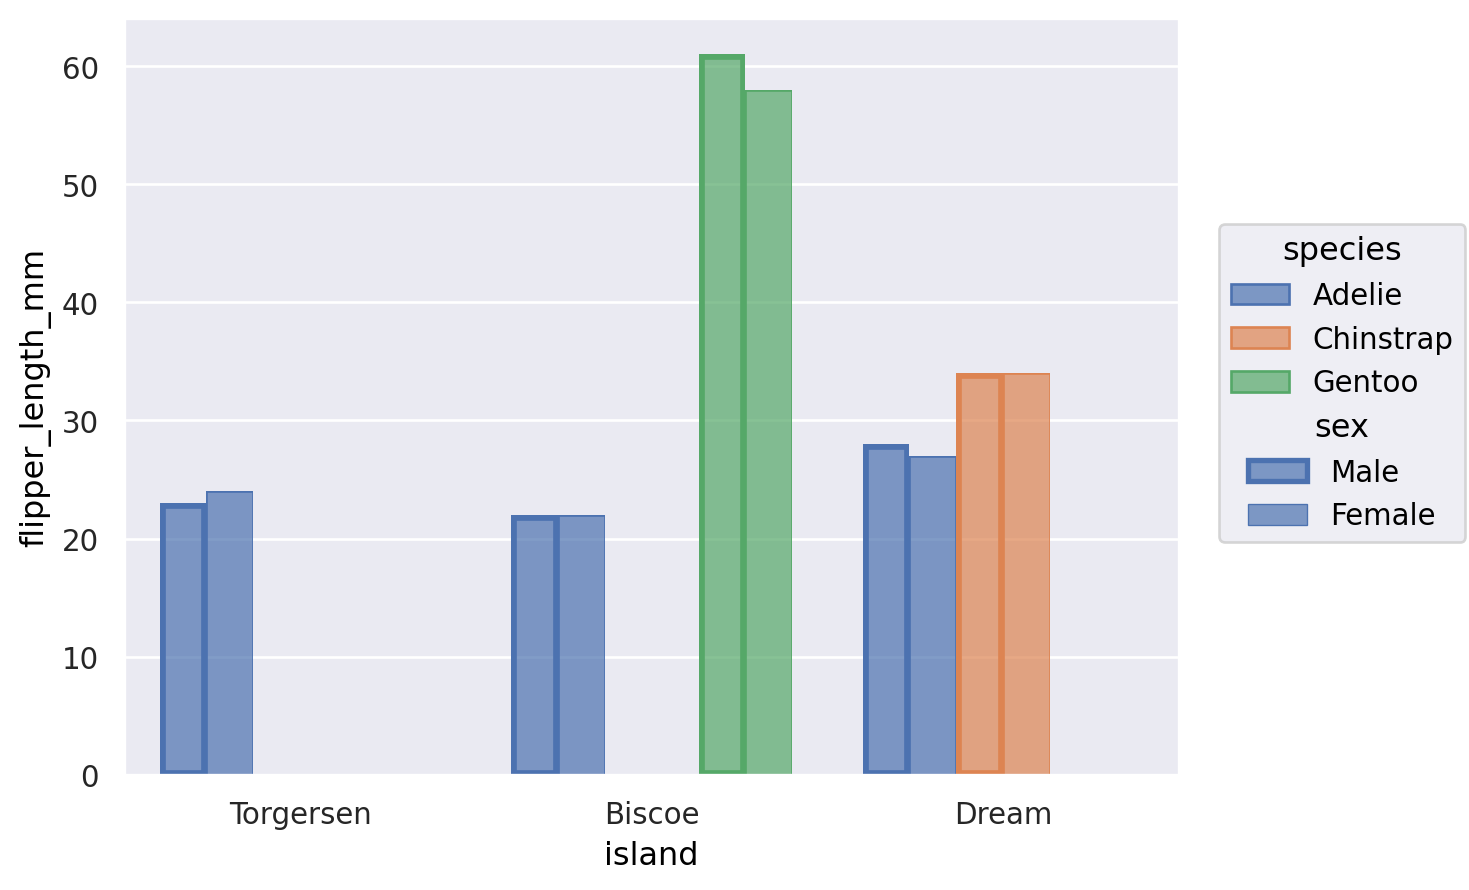

In [78]:
(
    so.Plot(data = penguins, x = "island",y = "flipper_length_mm")
    .add(so.Bar(), so.Hist(), so.Dodge(), color = "species", edgewidth = "sex")
)

In [ ]:
(
    so.Plot(data = penguins, x = "island",y = "flipper_length_mm")
    .add(so.Bar(), so.Hist(), so.Dodge(), color = "species", edgewidth = "sex")
)